# Sound Synthesis in Pyzls

Inspiration: blog post https://flothesof.github.io/Karplus-Strong-algorithm-Python.html

In [1]:
import pyzls
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

## A simple buffer library based on numpy

- `noise` returns a buffer randomly filled with -1, and 1.
- `freq_to_size` turns a frequency into a buffer size (wavetable synthesis)

In [2]:
@pyzls.lib("buffer", clear=True)
def noise(n: int) -> "'buff":
    import numpy as np
    return (2 * np.random.randint(0, 2, n) - 1).astype(np.float)

@pyzls.lib("buffer")
def get(b:"'buff", i:int) -> "'a":
    return b[i]

@pyzls.lib("buffer")
def update(b:"'buff" , i:int, v:"'a") -> "unit":
    b[i] = v

@pyzls.lib("buffer")
def size(b: "'buff") -> int:
    return len(b)

@pyzls.lib("buffer")
def freq_to_size(f: float, fs: int) -> int:
    return int(fs // f)

## Wavetable synthesis

- use a ring buffer as a lookup table
- sound is produced by repeatedly reading the buffer which produces a periodic signal

In [3]:
%%zelus -clear

let fs = 8000

open Buffer

let node wavetable (b, speed) = y where
  rec i = 0 fby (i+speed) mod size(b)
  and y = get(b, i)

Let's try different shapes.

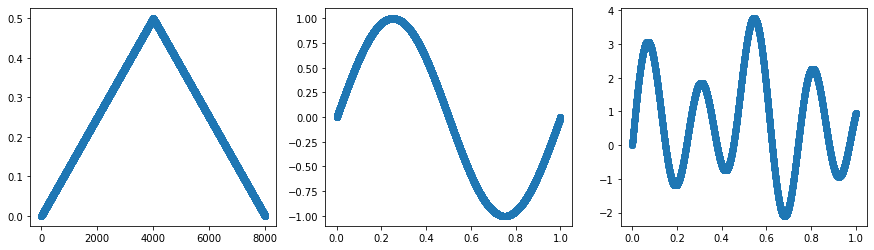

In [4]:
t = np.linspace(0, 1, num=fs)
table_sin = np.sin(2 * np.pi * t)
table_trig = t * (t < 0.5) + (1 - t) * (t > 0.5)
table_squiggle = np.sum([np.sin(2 * np.pi * t * f) for f in np.random.rand(4) * 5], axis=0)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes[0].plot(table_trig, "-o")
axes[1].plot(t, table_sin, '-o')
axes[2].plot(t, table_squiggle, '-o')

To run a zelus node:
1. instantiate the class
2. call the `reset` method to initialize the memories
3. fire the `step` method as many times as you want

In [5]:
w = wavetable()

w.reset()  
samples_sin = [w.step(table_sin, 440) for _ in range(2*fs)]

We can also reset and run the node with new inputs

In [6]:
w.reset()
samples_trig = [w.step(table_trig, 440) for _ in range(2*fs)]
w.reset()
samples_squiggle = [w.step(table_squiggle, 440) for _ in range(2*fs)]

Let's hear the results...

In [7]:
display(Audio(samples_sin, rate=fs))
display(Audio(samples_trig, rate=fs))
display(Audio(samples_squiggle, rate=fs))

Complexity of the wavetable is reflected in the spectrum

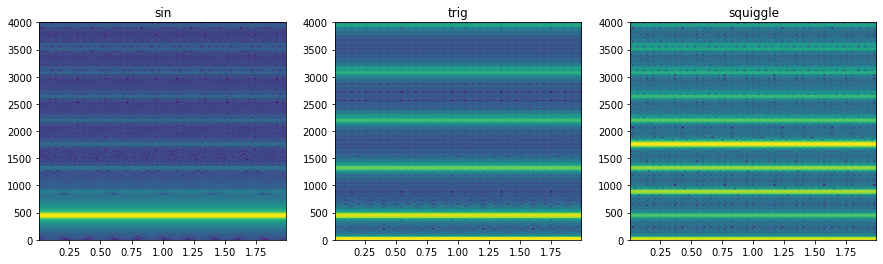

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

axes[0].set_title("sin")
_ = axes[0].specgram(samples_sin, Fs=fs)
axes[1].set_title("trig")
_ = axes[1].specgram(samples_trig, Fs=fs)
axes[2].set_title("squiggle")
_ = axes[2].specgram(samples_squiggle, Fs=fs)

## Karplus-Strong synthesis

_Digital Synthesis of Plucked-String and Drum Timbres_  K. Karplus and A. Strong
Computer Music Journal, Vol. 7, No. 2 (Summer, 1983), pp. 43-55

> The wavetable-synthesis technique is very simple but rather dull musically, since it produces purely periodic tones. Traditional musical instruments produce sounds that vary with time. This variation can be achieved in many ways on computers. The approach in FM synthesis, additive synthesis, subtractive synthesis, and waveshaping is to do further processing of the samples after taking them from the wavetable. All the algorithms described in this paper produce the variation in sound by modifying the wavetable itself.

The Karplus-Strong algorithm is a variation of wavetable synthesis where the ring buffer intialized with noise and dynamically updated with the following formula:

$
Y_t = \frac{1}{2} (Y_{t−p} + Y_{t−p−1})
$


<img src="Karplus-strong-schematic.png" style="float: left; width: 800px;">





In [9]:
%%zelus

open Buffer

let node karplus_strong(f) = y where
  rec init n = freq_to_size(f, fs)
  and init b = noise(n)
  and i = 0 fby (i+1) mod n
  and y = 0.5 *. (get(b, i) +. 0.0 fby y)
  and _ = update(b, i, y)

In [10]:
kp = karplus_strong()
kp.reset()  
samples = [kp.step(220) for _ in range(2*fs)]

Here we get the signal of a pinched string at 220Hz (A).

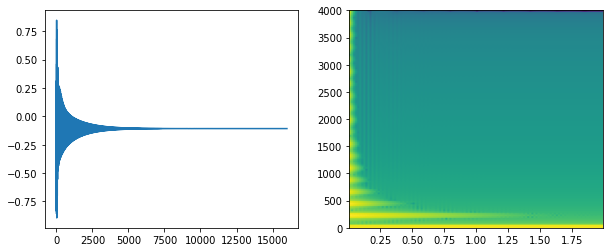

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(samples)
_ = axes[1].specgram(samples, Fs=fs)

In [12]:
Audio(samples, rate=fs)

## Simple player using parameterized states

In state `Play(f)`:
- pinch a string with frequency $f$
- wait 1s
- restart state `Play` with a new frequency $f*\sqrt{2}^{12}$ (one semitone higher with equal temperament)

In [13]:
%%zelus

let node seconds() = s where
  rec t = (0 fby t + 1) mod fs
  and s = (0 fby s) + if t = 0 then 1 else 0

let node scale() = o where
  rec automaton
  | Play(f) -> do  s = seconds()
               and o = karplus_strong(f)
               until (s = 1) then Play(f *. 1.05946)
  init Play(65.)

In [14]:
s = scale()
s.reset()  
samples = [s.step(_) for _ in range(8*fs)]
Audio(samples, rate=fs)

## A mysterious song...

Let's adapt the previous technique to play a score stored in a list.
Each element is a pair (pitch, duration).

In [15]:
%%zelus

let node tempo() = s where
  rec t = (0 fby t + 1) mod (fs / 8)
  and s = (0 fby s) + if t = 0 then 1 else 0

let node player(score) = o where
  rec automaton
  | Play(i) -> do  s = tempo()
               and f, t = get(score, i)
               and o = karplus_strong(f)
               until (s = t) then Play(i + 1)
  init Play(0)

In [16]:
m = {
    'G': 196,
    'A': 220,
    'B': 246.94,
    'C': 261.63,
    'D': 293.66,
    'E': 329.63,
    'F': 349.23,
}


score = [(m['G'], 4), (m['A'], 4),
    *([*[(m['C'], i) for i in [2, 2, 2, 1, 2, 1, 2]], (m['G'], 2), (m['A'], 2)] * 3)[:-2],
    (m['C'], 2), (m['C'], 2), (m['B'], 8)]


p = player()
p.reset()  
samples = [p.step(score*3) for _ in range(10*fs)]
Audio(samples, rate=fs)

### Parallel composition is free!

Let's add a baseline.

In [17]:
%%zelus

let node band(table, score, base) = o where
  rec h = player(score)
  and b = player(base)
  and o = h +. 0.25 *. b

In [18]:
base = [
    (fs, 8),
    *[(m['C']/4, 2), (m['C']/2, 2)] * 4,
    *[(m['F']/4, 2), (m['F']/2, 2)] * 4,
    *[(m['A']/2, 2), (m['A'], 2)] * 4,
    (m['G'], 2),(m['F']/2, 2), (m['E']/2, 2), (m['D']/2, 2)
]

b = band()
b.reset()  
samples = [b.step(table_squiggle, score * 3, base * 3) for _ in range(16*fs)]
Audio(samples, rate=fs)